# Exploratory Analysis
This analysis is to find optimal features for identifying churn.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('merged_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Client_ID                             2142 non-null   object 
 1   Sale_Frequency                        2142 non-null   int64  
 2   Preferred_Service_Time                2142 non-null   float64
 3   Favorite_Sales_Item                   2142 non-null   object 
 4   Ever_Purchased_Addons                 2142 non-null   int64  
 5   Ever_Purchased_Chair_Session          2142 non-null   int64  
 6   Ever_Purchased_Manager_Owner_Session  2142 non-null   int64  
 7   Ever_Late_Cancel                      2142 non-null   int64  
 8   Non_Member_Purchase_Rate              2142 non-null   float64
 9   Member_Status                         2142 non-null   object 
 10  Member_Next_Autopay_Amount            2142 non-null   float64
 11  Member_Age       

## Visualizations

### Numerical features

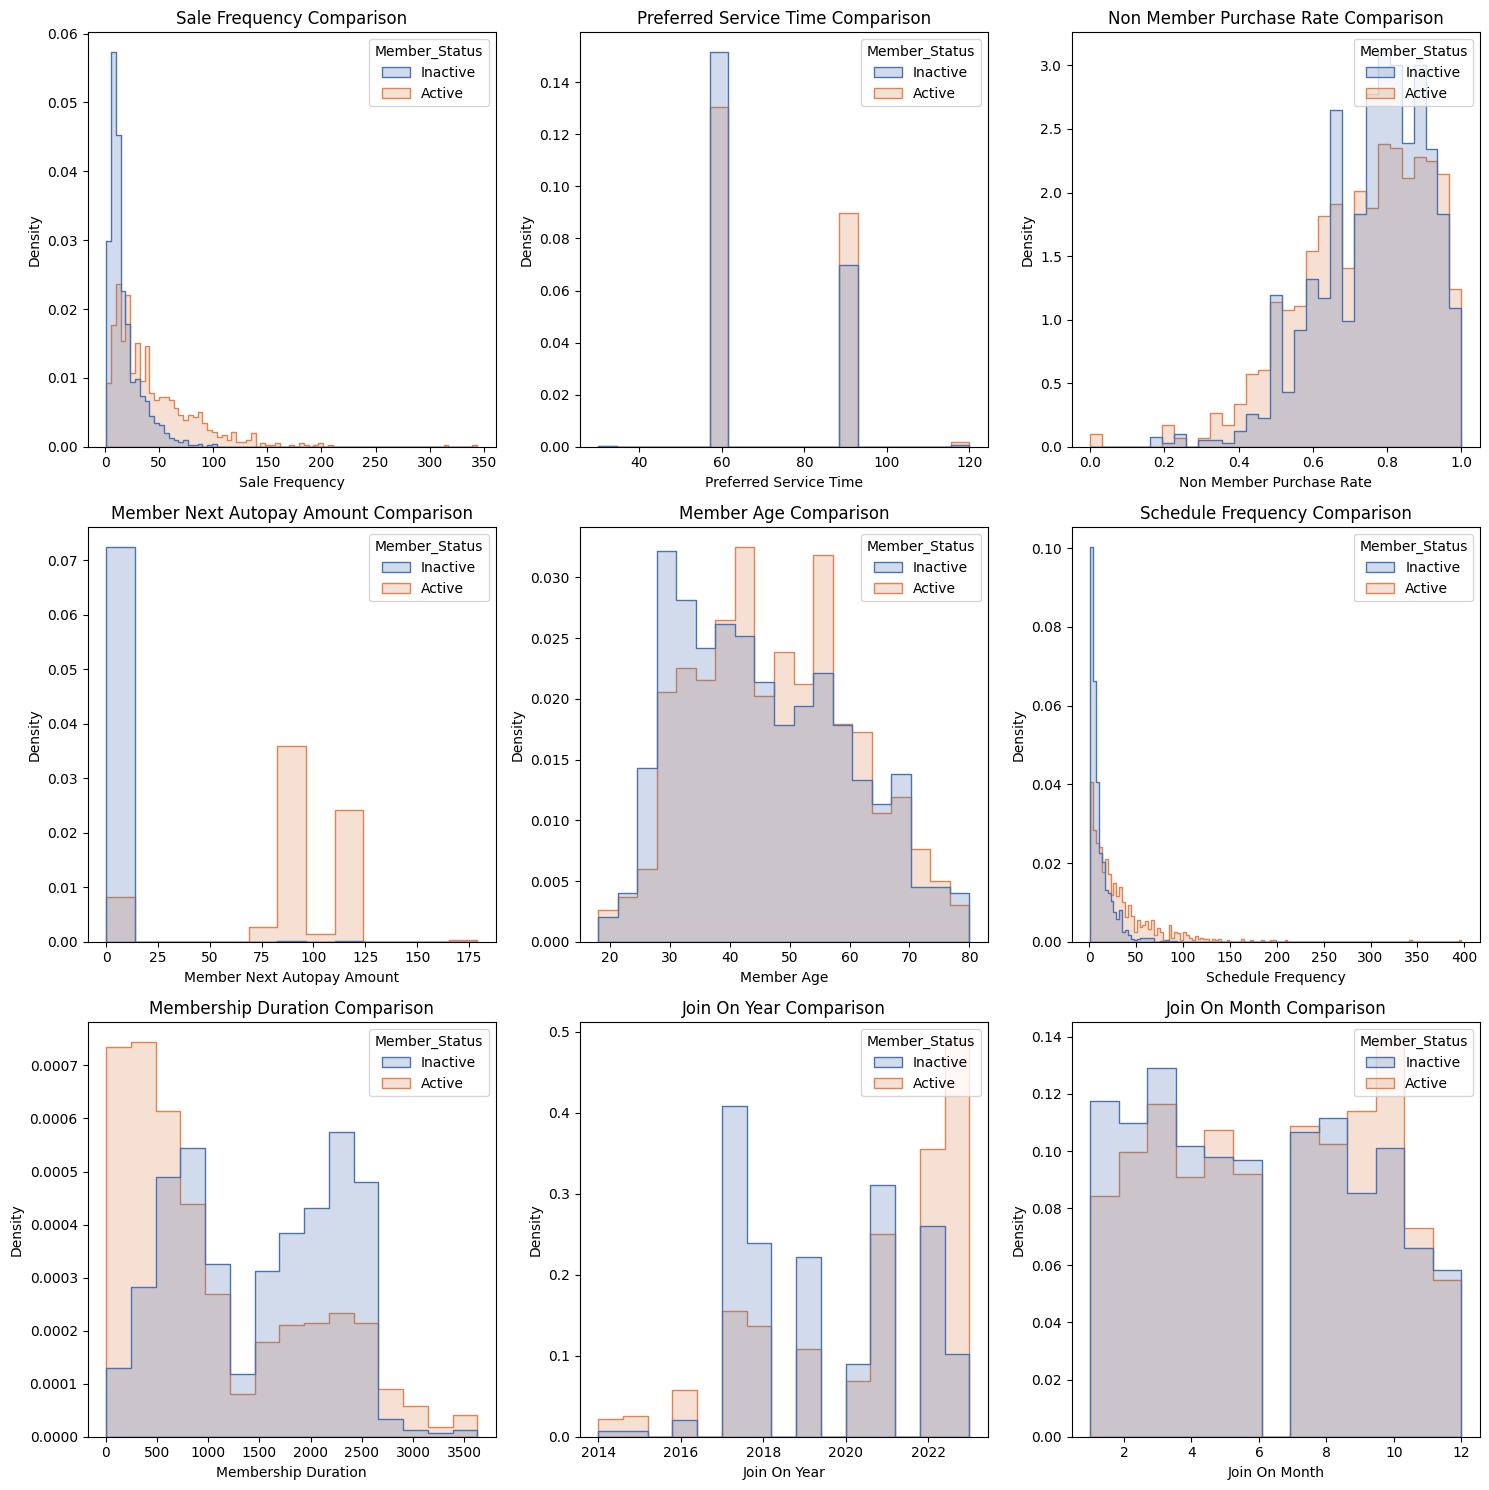

In [4]:
# Define the numerical features to plot, excluding those specified by the user
numerical_features = [
    'Sale_Frequency', 'Preferred_Service_Time', 'Non_Member_Purchase_Rate',
    'Member_Next_Autopay_Amount', 'Member_Age', 'Schedule_Frequency',
    'Membership_Duration', 'Join_On_Year', 'Join_On_Month'
]

# Determine the number of rows and columns for subplots
num_features = len(numerical_features)
ncols = 3
nrows = (len(numerical_features) + ncols - 1) // ncols  # Ceiling division

# Create a superplot with subplots for each numerical feature, ensuring that the legend is displayed correctly
plt.figure(figsize=(15, 5 * nrows))

for i, feature in enumerate(numerical_features):
    plt.subplot(nrows, ncols, i+1)
    sns.histplot(data=data, x=feature, hue='Member_Status', element='step', stat='density', common_norm=False, palette='deep')
    plt.title(f'{feature.replace("_", " ").title()} Comparison')
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Density')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Categorical features

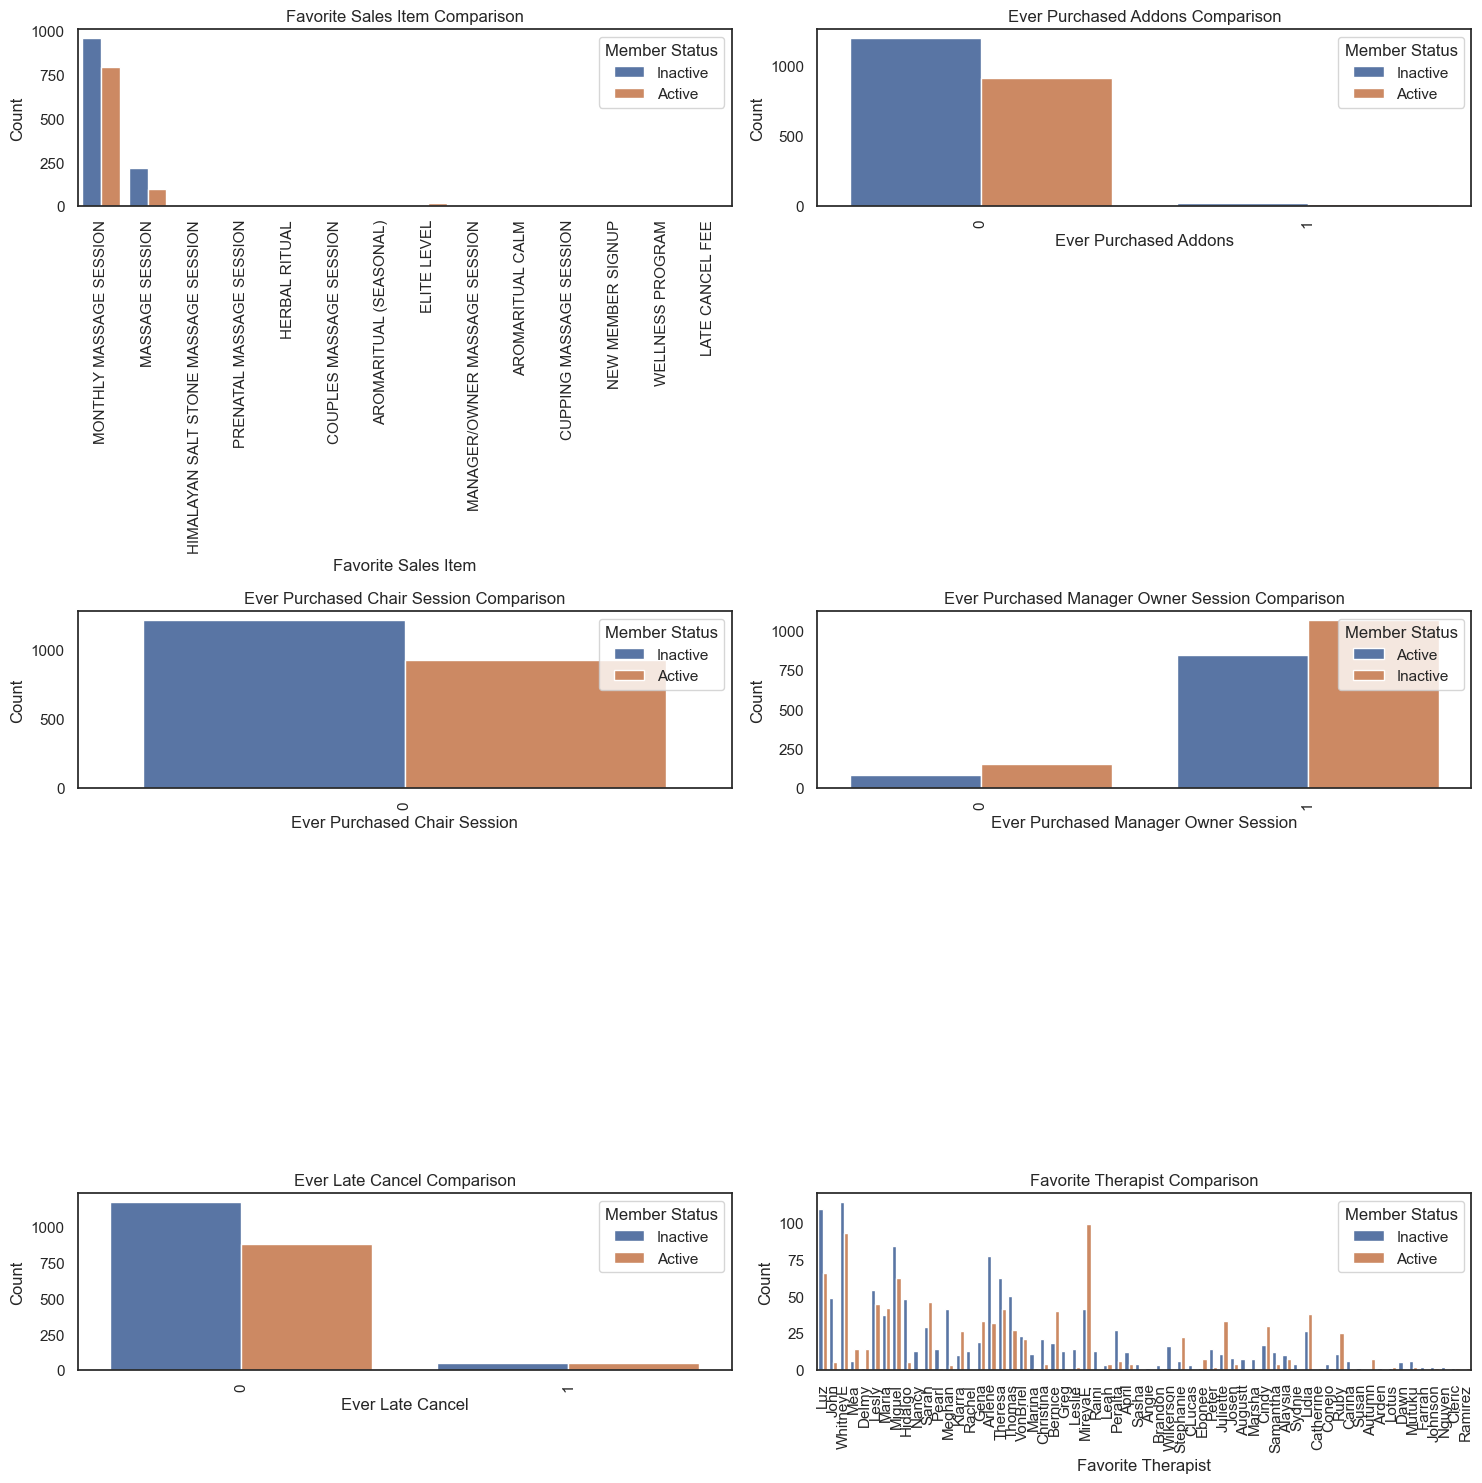

In [5]:
# Define the categorical features to plot, including those starting with "Ever Purchased" but excluding 'Client_ID' and 'Member_Status'
categorical_features = [
    'Favorite_Sales_Item', 'Ever_Purchased_Addons',
    'Ever_Purchased_Chair_Session', 'Ever_Purchased_Manager_Owner_Session',
    'Ever_Late_Cancel', 'Favorite_Therapist'
]

# Determine the number of rows and columns for subplots
num_features = len(categorical_features)
ncols = 2  # Set to 2 for better readability of bar plots
nrows = num_features // ncols + (num_features % ncols > 0)

# Create a superplot with subplots for each categorical feature
plt.figure(figsize=(15, 5 * nrows))
sns.set(style="white")  # Set style to remove gridlines

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(nrows, ncols, i)
    sns.countplot(data=data, x=feature, hue='Member_Status', palette='deep')
    plt.title(f'{feature.replace("_", " ").title()} Comparison')
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Count')
    plt.legend(title='Member Status', loc='upper right')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Adjust layout
plt.tight_layout()
plt.show()

### Correlation heatmap

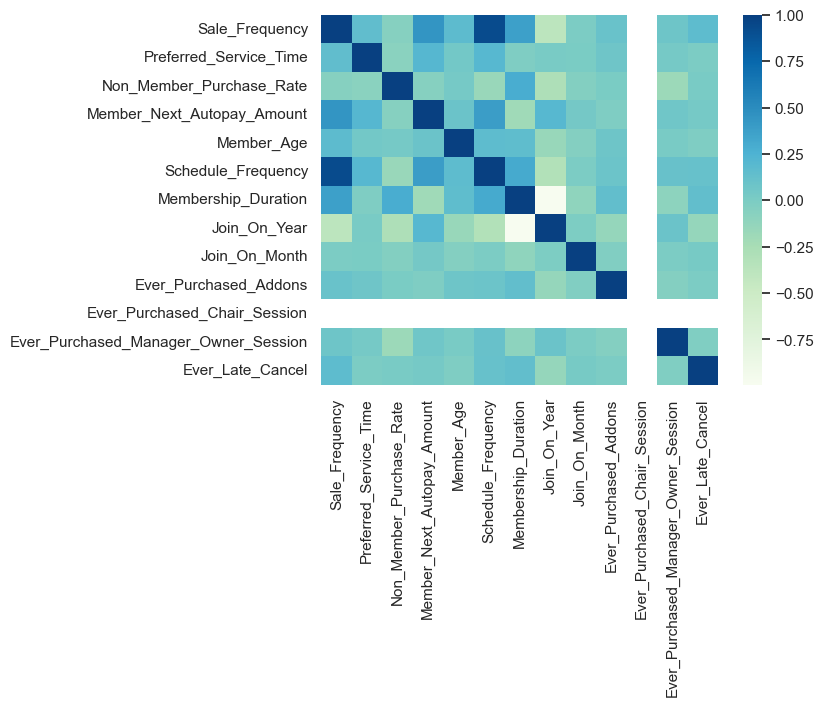

In [6]:
sns.heatmap(data[numerical_features + ['Ever_Purchased_Addons','Ever_Purchased_Chair_Session','Ever_Purchased_Manager_Owner_Session','Ever_Late_Cancel']].corr(), cmap='GnBu')
plt.show()

## Hypothesis Tests

In [7]:
from scipy.stats import mannwhitneyu, chi2_contingency

# Function to perform Mann-Whitney U Test for numerical features
def perform_mannwhitneyu_test(data, features, group_col):
    results = {}
    # Split the data into groups based on member status
    groups = data[group_col].unique()
    if len(groups) == 2:  # Ensure there are only two groups for the test
        group1_data = data[data[group_col] == groups[0]]
        group2_data = data[data[group_col] == groups[1]]
        for feature in features:
            u_statistic, p_value = mannwhitneyu(group1_data[feature], group2_data[feature], alternative='two-sided')
            results[feature] = p_value
    else:
        raise ValueError("Mann-Whitney U Test requires exactly two groups.")
    return results

# Perform Mann-Whitney U Test for all numerical features
mwu_test_results = perform_mannwhitneyu_test(data, numerical_features, 'Member_Status')

# Function to perform Chi-Square Test for categorical features
def perform_chi2_test(data, features, group_col):
    results = {}
    for feature in features:
        contingency_table = pd.crosstab(data[feature], data[group_col])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        results[feature] = p
    return results

# Perform Chi-Square Test for all categorical features
chi2_test_results = perform_chi2_test(data, categorical_features, 'Member_Status')

mwu_test_results, chi2_test_results

({'Sale_Frequency': 1.7341997354633787e-94,
  'Preferred_Service_Time': 4.117809916793635e-06,
  'Non_Member_Purchase_Rate': 0.0005859472231105075,
  'Member_Next_Autopay_Amount': 0.0,
  'Member_Age': 0.00014952238041308655,
  'Schedule_Frequency': 4.343709144925432e-76,
  'Membership_Duration': 3.167928551156896e-42,
  'Join_On_Year': 1.0880099505688853e-40,
  'Join_On_Month': 0.0035223236259119364},
 {'Favorite_Sales_Item': 0.00038706290773729964,
  'Ever_Purchased_Addons': 0.4942666705230757,
  'Ever_Purchased_Chair_Session': 1.0,
  'Ever_Purchased_Manager_Owner_Session': 0.00708136457855532,
  'Ever_Late_Cancel': 0.2170728214219506,
  'Favorite_Therapist': 3.3534869380534714e-54})

In [8]:
# List features with test results that are not statistically significant at the 0.05 level
not_significant_features = {feature: p_value for feature, p_value in mwu_test_results.items() if p_value >= 0.05}
not_significant_features.update({feature: p_value for feature, p_value in chi2_test_results.items() if p_value >= 0.05})
not_significant_features

{'Ever_Purchased_Addons': 0.4942666705230757,
 'Ever_Purchased_Chair_Session': 1.0,
 'Ever_Late_Cancel': 0.2170728214219506}